# Preference Learning - Part II
## 1. Principle Component Analysis (PCA)
## 2. Gaussian Mixture Models (GMM)
## 3. Groups' Price Responsiveness

In [2]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
from pandas.io.json import json_normalize #package for flattening json in pandas df
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime

## 1. Principle Component Analysis
We first focus on the non-event data. For each hour, 

(1) the first approach is we do principle component analysis and get several explanable top PCs and then use the top PCs to do K-mean clustering to find out groups; 

(2) the second approach is forget about PCA, and start by drawing histogram of distribution on a temp, consumption, occurence 3D space, and using GMM to fit the data and find out the classes.

In [3]:
# Import all preprocessed data necessary for the analysis
df_tou1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\data_tables\\Consumption_tou2013_1h.csv")
df_Ntou1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\data_tables\\Consumption_Ntou2013_1h.csv")
df_wea1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\weather\\LondonWeather2013_interpolated.csv")
df_tariff_1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\data_tables\\df_tariff_1h.csv")

(1) In PCA, we don't consider normalization since all the consumptions have the same unit, we care about the absolute change rather than relative change since DR targets the customer who has largest potential shiftable load instead of largest price-responsiveness rate. Also we have seperate data by hours, so the temp-consumption relationship at different hours has been treated seprately and equally, so the time effect won't be a concern to let us normalize the data.

In [68]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Test with 9:00 am TOU data
x = df_tou1h[df_tou1h.GMT.str.contains('09:00:00')]
x.set_index('GMT', inplace = True)
x = x.transpose().dropna() # data for the specific hour, and filtering out null value
x = x.values
x = StandardScaler().fit_transform(x)
pca = PCA(0.95)
principleComponents = pca.fit_transform(x)
principleDf = pd.DataFrame(data = principleComponents)
principleDf
# x.dropna()

,0,1,2,3,4,5,6,7,8,9,...,185,186,187,188,189,190,191,192,193,194
0,-7.981755,-0.441919,0.062229,0.450244,-1.203530,0.744873,-0.528304,-0.239166,0.392450,0.803503,...,-0.057826,0.752684,0.209256,0.230403,-0.124234,0.208267,-0.285439,0.202225,0.747388,-0.330643
1,-4.339880,-0.913629,3.838253,1.317686,-1.661949,0.925002,1.109099,-0.781614,-1.075394,-3.014815,...,-1.363839,-1.282611,-0.404133,0.579150,-0.703451,-0.367846,1.194018,-0.106555,0.118536,-0.833954
2,-8.806011,2.382203,2.238180,0.227994,0.235453,0.778656,-0.592881,-0.342003,-1.280006,0.223586,...,0.599687,-0.104334,0.097967,0.173075,-0.344925,-0.217913,-0.484005,-0.262506,0.500889,0.244080
3,-3.549811,-1.133521,-0.434090,0.035322,0.156714,-0.198780,-0.146566,-0.315979,-0.185393,-0.022778,...,0.220971,-0.386707,-0.098509,-0.099561,0.012324,0.109608,-0.241433,-0.367468,0.401189,0.294975
4,-1.867069,-2.054949,-2.320342,-0.005976,-0.330819,-0.740272,-0.023838,-0.385411,-0.054628,0.655352,...,-0.129322,0.697772,0.380192,0.553340,0.005691,0.387323,0.702020,-0.402965,0.004136,1.030403
5,-2.321969,0.129975,-0.324063,-0.536397,-0.434681,-0.234046,-0.401940,0.074142,-0.375534,-0.242466,...,0.136082,0.816392,0.492347,-1.240955,0.400715,-0.419873,0.022879,-0.601889,0.468620,-0.434144
6,-7.670423,1.587292,-0.267504,-0.224689,0.868655,-0.490466,-0.200803,-0.007492,-0.187607,-0.394143,...,-0.020195,-0.224844,-0.248368,-0.453173,0.134729,-0.137283,-0.285020,0.089038,-0.015968,-0.189430
7,0.601119,-1.735808,5.732522,2.588213,1.027339,-0.354655,-0.895547,-0.336493,0.870060,-1.400755,...,0.126448,0.326875,0.605153,-0.171808,-0.059111,0.162056,0.319368,-0.632910,-0.371426,-0.046913
8,-15.079286,1.922457,-0.937212,0.663959,0.018258,0.391816,0.042849,0.406708,-0.165103,0.089665,...,0.014645,0.101058,0.020141,-0.032313,-0.030394,-0.044218,-0.038837,0.054288,0.084362,-0.043678
9,-0.854761,1.584050,0.411604,1.120179,-0.425164,-0.189588,-0.001941,0.442067,1.094248,-0.126042,...,-0.017525,-0.361897,-0.696844,-0.204885,0.522939,0.211791,-0.167762,-0.233397,0.961315,-0.930206


In [69]:
pca.components_[0]

array([0.04526809, 0.05424037, 0.05378507, 0.05304063, 0.04965814,
       0.04682289, 0.05116981, 0.05515424, 0.05232522, 0.05765624,
       0.05826776, 0.05233085, 0.05516979, 0.05866594, 0.05577057,
       0.05366148, 0.06077023, 0.05686823, 0.0538988 , 0.04924719,
       0.05680931, 0.06303809, 0.05755883, 0.05941713, 0.06093735,
       0.05149618, 0.05469271, 0.05845232, 0.06138725, 0.06020557,
       0.05927966, 0.05729385, 0.05250879, 0.05247287, 0.06027971,
       0.0632952 , 0.05850438, 0.05747283, 0.05961975, 0.05589682,
       0.05746589, 0.0613622 , 0.06191405, 0.05870416, 0.06001588,
       0.06038495, 0.05799266, 0.05427792, 0.0564315 , 0.05906538,
       0.05436065, 0.05574031, 0.05776655, 0.05840559, 0.0562652 ,
       0.05722266, 0.06055883, 0.06149364, 0.05531744, 0.06005957,
       0.057213  , 0.05436276, 0.06173789, 0.06037502, 0.062042  ,
       0.05835481, 0.05916275, 0.05572818, 0.05585894, 0.06176505,
       0.05919003, 0.06091819, 0.06288778, 0.05851173, 0.05065

In [77]:
pca2.components_[0]

array([0.04506198, 0.05643014, 0.05064015, 0.04849938, 0.04729118,
       0.05013514, 0.05276414, 0.05735319, 0.05436557, 0.07143631,
       0.06942483, 0.07204169, 0.06578583, 0.08014974, 0.08776788,
       0.07191214, 0.08582941, 0.08938185, 0.08950622, 0.08820993,
       0.08691155, 0.0984511 , 0.08796916, 0.08708516, 0.10073649,
       0.08083025, 0.07707166, 0.07044581, 0.06467571, 0.06173517,
       0.06383528, 0.06890395, 0.06203282, 0.07519853, 0.07006274,
       0.08039151, 0.07349349, 0.09459587, 0.07608452, 0.08040507,
       0.08297709, 0.09200309, 0.09296181, 0.07997316, 0.07538164,
       0.07478871, 0.06603292, 0.05849042, 0.06486685, 0.07763019,
       0.06973396, 0.07254064, 0.08973086, 0.08313832, 0.08630246,
       0.06992489, 0.07492218, 0.07814005, 0.08447553, 0.07142797,
       0.08074256, 0.07248881, 0.0725505 , 0.07229541, 0.06151274,
       0.06145342, 0.06572447, 0.06191417, 0.07102775, 0.08388575,
       0.08975863, 0.0845282 , 0.08602106, 0.07027516, 0.06870

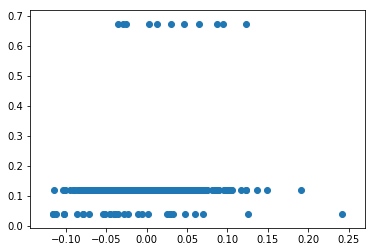

In [113]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.scatter(pca2.components_[11], df_tariff_1h.Price[df_tou1h.GMT.str.contains('09:00:00')])

In [101]:
df_tariff_1h

,GMT,Price,Event_tags
0,2013-01-01 00:00:00,0.1176,NaN
1,2013-01-01 01:00:00,0.1176,NaN
2,2013-01-01 02:00:00,0.1176,NaN
3,2013-01-01 03:00:00,0.1176,NaN
4,2013-01-01 04:00:00,0.1176,NaN
5,2013-01-01 05:00:00,0.1176,NaN
6,2013-01-01 06:00:00,0.1176,NaN
7,2013-01-01 07:00:00,0.1176,NaN
8,2013-01-01 08:00:00,0.1176,NaN
9,2013-01-01 09:00:00,0.1176,NaN


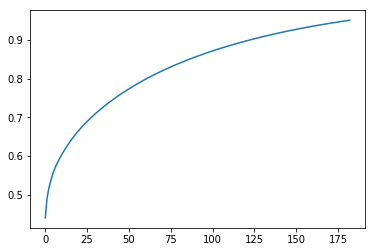

In [75]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Test with 9:00 am TOU data
y = df_tou1h[df_tou1h.GMT.str.contains('09:00:00')]
y.set_index('GMT', inplace = True)
y = y.transpose().dropna() # data for the specific hour, and filtering out null value
pca2 = PCA(0.95)
principleComponents2 = pca2.fit_transform(y)
principleDf2 = pd.DataFrame(data = principleComponents2)
plt.plot(np.cumsum(pca2.explained_variance_ratio_))

In [54]:
y = df_Ntou1h[df_Ntou1h.GMT.str.contains('09:00:00')]
y.set_index('GMT', inplace = True)
y = y.transpose()
y.dropna()

GMT,2013-01-01 09:00:00,2013-01-02 09:00:00,2013-01-03 09:00:00,2013-01-04 09:00:00,2013-01-05 09:00:00,2013-01-06 09:00:00,2013-01-07 09:00:00,2013-01-08 09:00:00,2013-01-09 09:00:00,2013-01-10 09:00:00,...,2013-12-22 09:00:00,2013-12-23 09:00:00,2013-12-24 09:00:00,2013-12-25 09:00:00,2013-12-26 09:00:00,2013-12-27 09:00:00,2013-12-28 09:00:00,2013-12-29 09:00:00,2013-12-30 09:00:00,2013-12-31 09:00:00
N0000,0.448,0.528,0.619,0.318,0.607,0.660,0.351,0.613,0.361,0.404,...,0.483,0.369,0.360,1.982,1.552,0.362,0.340,0.324,0.594,0.415
N0001,0.228,0.243,0.263,0.264,0.234,0.262,0.261,0.951,0.947,0.093,...,0.489,0.462,0.606,0.650,0.650,0.643,0.626,0.661,0.657,0.637
N0002,0.238,0.594,0.487,0.615,0.316,0.539,0.195,0.484,0.584,0.523,...,0.387,0.457,0.060,0.078,0.052,0.315,0.528,0.234,0.473,0.259
N0003,0.598,0.543,0.371,0.920,0.351,0.758,0.570,0.398,0.433,0.416,...,0.734,0.750,0.490,1.506,0.400,1.009,0.569,0.645,1.216,0.508
N0004,0.305,0.344,0.417,0.571,0.115,0.116,0.405,0.427,0.272,0.461,...,0.382,0.399,0.428,0.771,0.356,0.209,0.243,2.319,0.526,0.855
N0007,0.167,0.163,0.166,0.151,0.169,0.148,0.147,0.155,0.263,0.198,...,0.326,0.194,0.307,0.156,0.166,0.157,0.496,0.380,0.163,0.272
N0008,0.151,0.480,0.627,0.978,0.651,0.304,0.480,1.140,0.481,0.556,...,0.684,0.543,0.130,0.161,0.162,0.139,0.644,0.165,0.692,0.302
N0009,0.947,0.852,0.801,0.564,0.884,0.849,0.580,0.742,0.606,0.592,...,1.363,0.636,0.992,1.894,1.285,1.658,2.639,1.413,0.957,0.621
N0010,0.576,0.585,0.714,0.937,0.621,0.771,2.688,3.640,0.843,3.347,...,1.303,1.185,1.571,2.877,0.915,0.366,0.362,0.465,1.009,0.656
N0011,0.490,0.563,0.491,0.445,0.661,0.378,0.381,0.435,0.441,0.532,...,0.497,0.337,0.472,0.480,0.481,0.412,0.433,0.346,0.464,0.478
